# 实现深层神经网络

本章我们将编码完成全连接神经网络，并使用CIFAR-10数据集进行测试，在本章练习中我们将完成：
- 1.仿射层传播
- 2.ReLU层传播
- 3.组合单层神经元
- 4.实现浅层全连接神经网络
- 5.实现深层全连接神经网络

In [2]:
# -*- coding: utf-8 -*-
import time
import numpy as np
import matplotlib.pyplot as plt
from classifiers.chapter3 import *
from utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] =(10.0, 8.0) # 设置默认绘图尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  #计算相对错误
  return np.max(np.abs(x - y) /(np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# 将CIFAR10数据集的导入，切片，预处理操作进行封装
data = get_CIFAR10_data()  #获取数据
# 训练数据
X_train =data['X_train']
y_train =data['y_train']
# 验证数据
X_val = data['X_val']
y_val = data['y_val']
# 测试数据
X_test = data['X_test']
y_test = data['y_test']
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## 仿射层前向传播

仿射（affine）传播就是将各个输入特征进行加权求和，如果下一层有m个神经元，那就相当于线性代数中的m组线性方程式。

进行测试：

In [4]:
# 测试affine_forward 函数
# np.linspaces，规定起点、终点（包含）、返回array的长度，返回一个两端点间数值平均分布的array。
num_inputs = 2
input_shape =(4, 5, 6)
output_dim = 3 #输出维度

# 2*4*5*6
input_size = num_inputs * np.prod(input_shape)
# 3*4*5*6
weight_size = output_dim * np.prod(input_shape)

# 初始化输入参数
x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

# 测试affine_forward函数
out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# 比较你的实现结果和正确结果。该误差应该小于1e-9。
print('测试 affine_forward 函数:')
print('误差: ', rel_error(out, correct_out))

测试 affine_forward 函数:
误差:  9.769847728806635e-10


## 仿射层反向传播

在前向传播中，实现的启示就是out=x1*w1+x2*w2+b这个函数，那仿射层的反向传播，其实就是将x，w，b各自对应的梯度求出即可。需要注意的是，在缓存中我们存储的是原始数据的四维图像数据。因此，同前向传播一样，首先将数据转换为二维数据后，再进行求解。


In [5]:
# 测试 affine_backward 函数
from utils.gradient_check import *

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# 相对误差应该小于1e-10
print('测试 affine_backward 函数:')
print('dx 误差: ', rel_error(dx_num, dx))
print('dw 误差: ', rel_error(dw_num, dw))
print('db 误差: ', rel_error(db_num, db))

测试 affine_backward 函数:
dx 误差:  8.246429923021287e-11
dw 误差:  9.774704022249044e-11
db 误差:  1.8324937594438097e-11


## ReLU层前向传播

ReLU激活函数的公式为max(0, x)，我们直接使用NumPy提供的内置公式即可。实现 relu_forward 激活函数的前向传播，并使用下列代码进行测试:

In [6]:
# 测试relu_forward 函数

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# 比较输出结果. 其误差大约为 1e-8
print('测试 relu_forward 函数:')
print('误差: ', rel_error(out, correct_out))

测试 relu_forward 函数:
误差:  4.999999798022158e-08


## ReLU层反向传播

实现 relu_backward函数并使用数值梯度进行检验：

In [7]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# 其相对误差大约为1e-12
print('测试 relu_backward 函数:')
print('dx 误差: ', rel_error(dx_num, dx))

测试 relu_backward 函数:
dx 误差:  3.275616534549067e-12


## 完整的神经元层

接下来我们将上述的affine传播，和ReLU传播组合在一起，形成一层完整的神经元层。

在你实现affine_relu_forward和affine_relu_backward函数之后，运行下面的代码进行梯度检验：

In [8]:
#初始化。
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

#执行ReLU，获取分析梯度。
out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

#获取数值梯度。
dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

#比较相对误差。
print('测试 ReLU神经元相对误差:')
print('dx 误差: ', rel_error(dx_num, dx))
print('dw 误差: ', rel_error(dw_num, dw))
print('db 误差: ', rel_error(db_num, db))

测试 ReLU神经元相对误差:
dx 误差:  3.201929439745625e-11
dw 误差:  3.219935510377178e-09
db 误差:  3.2756942145383654e-12


## 输出层：Softmax

运行下列代码以确认我们的实现是正确的：

In [9]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)

y = np.random.randint(num_classes, size=num_inputs)
dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# 测试 softmax_loss 函数. 损失值大约为 2.3 dx 误差大约为 1e-8
print('\n测试 softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


测试 softmax_loss:
loss:  2.302394306232496
dx error:  8.016008070036267e-09


## 浅层神经网络

现在我们将实现浅层全连接神经网络，打开chapter3\shallow_layer_net.py文件，阅读内容完成相应任务后，执行下面代码进行验证。

In [10]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = ShallowLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('测试初始化 ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
# assert(W1_std < std / 10, '第一层权重初始化有问题')
# assert(np.all(b1 == 0), '第一层偏置初始化有问题')
# assert(W2_std < std / 10, '第二层权重初始化有问题')
# assert(np.all(b2 == 0), '第二层偏置初始化有问题')

print('测试前向传播过程 ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
    [[11.53165108,    12.2917344,     13.05181771,    13.81190102,    14.57198434, 15.33206765,    16.09215096],
     [12.05769098,    12.74614105,    13.43459113,    14.1230412,     14.81149128, 15.49994135,    16.18839143],
     [12.58373087,    13.20054771,    13.81736455,    14.43418138,    15.05099822, 15.66781506,    16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
# assert(scores_diff < 1e-6, '前向传播有问题')

# print('测试训练损失(无正则化)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
# assert(abs(loss - correct_loss) < 1e-10, '训练阶段的损失值(无正则化)有问题')

print('测试训练损失(正则化0.1)')
model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
# assert(abs(loss - correct_loss) < 1e-10, '训练阶段的损失值(有正则化)有问题')

for reg in [0.0, 0.7]:
    print('梯度检验，正则化系数 = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print('%s 相对误差: %.2e' %(name, rel_error(grad_num, grads[name])) )

测试初始化 ... 
测试前向传播过程 ... 
测试训练损失(正则化0.1)
梯度检验，正则化系数 =  0.0
W1 相对误差: 1.52e-08
W2 相对误差: 3.48e-10
b1 相对误差: 6.55e-09
b2 相对误差: 4.33e-10
梯度检验，正则化系数 =  0.7
W1 相对误差: 8.18e-07
W2 相对误差: 2.85e-08
b1 相对误差: 1.09e-09
b2 相对误差: 9.09e-10


## 训练浅层全连接网络

阅读 ShallowLayerNet.train()以及predict()函数，确保自己了解整个流程

In [11]:
input_size = 32 * 32 * 3
hidden_size = 100
num_classes = 10
net = ShallowLayerNet(input_size, hidden_size, num_classes)

# 训练网络
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=500,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=0.6, verbose=True)

# 验证结果
val_acc =(net.predict(X_val) == y_val).mean()
print('最终验证正确率: ', val_acc)
print('历史最佳验证正确率: ', stats['best_val_acc'])

迭代次数 0 / 2000: 损失值 2.393552
迭代次数 100 / 2000: 损失值 1.841475
迭代次数 200 / 2000: 损失值 1.806116
迭代次数 300 / 2000: 损失值 1.681771
迭代次数 400 / 2000: 损失值 1.610647
迭代次数 500 / 2000: 损失值 1.602736
迭代次数 600 / 2000: 损失值 1.611873
迭代次数 700 / 2000: 损失值 1.637565
迭代次数 800 / 2000: 损失值 1.608373
迭代次数 900 / 2000: 损失值 1.531719
迭代次数 1000 / 2000: 损失值 1.468017
迭代次数 1100 / 2000: 损失值 1.395518
迭代次数 1200 / 2000: 损失值 1.465631
迭代次数 1300 / 2000: 损失值 1.385197
迭代次数 1400 / 2000: 损失值 1.477168
迭代次数 1500 / 2000: 损失值 1.437521
迭代次数 1600 / 2000: 损失值 1.497306
迭代次数 1700 / 2000: 损失值 1.462852
迭代次数 1800 / 2000: 损失值 1.439107
迭代次数 1900 / 2000: 损失值 1.401284
最终验证正确率:  0.532
历史最佳验证正确率:  0.534


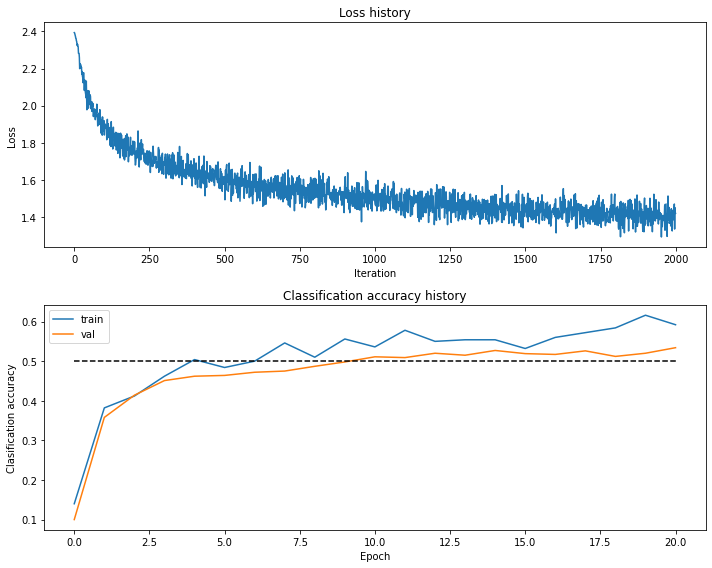

In [12]:
# 绘制损失函数变化曲线
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.plot([0.5] * len(stats['val_acc_history']), 'k--')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
# 添加图标
plt.legend()
# 控制布局
plt.tight_layout()
plt.show()

## 深层全连接网络

接下来我们将实现深层的全连接网络，由于我们以及实现了浅层网络，深层网络的实现将变得很简单。

深层神经网络相比于浅层神经网络，虽然仅仅是隐藏层数量变多而已，但它却具有了浅层网络没有的强大能力。由于我们已经实现了浅层网络，深层网络的实现将变得非常简单。现在要做的仅仅是将浅层网络中固定的单隐藏层变成任意多层即可。在深层全连接神经网络，隐藏层使用ReLU作为激活函数，输出层使用Softmax作为分类器。

In [13]:
N, D, H1, H2,H3, C = 2, 15, 20, 30, 20, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 0.11, 3.14]:
    print('权重衰减系数= ', reg)
    model = FullyConnectedNet(input_dim=D,hidden_dims=[H1, H2,H3],num_classes=C,reg=reg, weight_scale=5e-2)

    loss, grads = model.loss(X, y)
    print('初始化化损失值: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s 相对误差: %.2e' %(name, rel_error(grad_num, grads[name])))

权重衰减系数=  0
初始化化损失值:  2.302159545825584
W1 相对误差: 7.30e-07
W2 相对误差: 1.58e-06
W3 相对误差: 1.46e-05
W4 相对误差: 2.62e-07
b1 相对误差: 1.09e-07
b2 相对误差: 6.68e-08
b3 相对误差: 7.98e-09
b4 相对误差: 1.66e-10
权重衰减系数=  0.11
初始化化损失值:  2.5476208798306548
W1 相对误差: 2.01e-06
W2 相对误差: 2.32e-06
W3 相对误差: 2.71e-07
W4 相对误差: 3.10e-07
b1 相对误差: 5.28e-08
b2 相对误差: 1.34e-07
b3 相对误差: 1.14e-08
b4 相对误差: 1.25e-10
权重衰减系数=  3.14
初始化化损失值:  8.634845503833256
W1 相对误差: 8.14e-09
W2 相对误差: 6.13e-07
W3 相对误差: 4.64e-08
W4 相对误差: 7.77e-06
b1 相对误差: 1.01e-06
b2 相对误差: 7.53e-08
b3 相对误差: 1.53e-08
b4 相对误差: 3.77e-10


iteration 0 / 20: loss 1151.183192


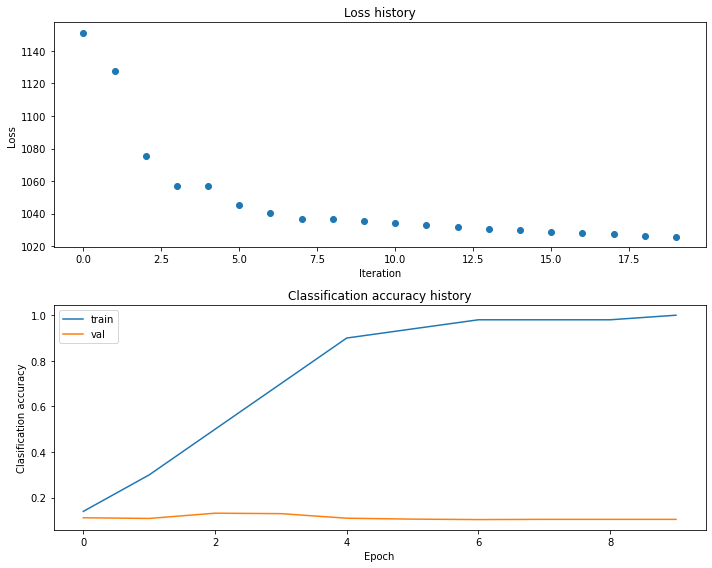

In [14]:
# 在小数据集上测试训练效果，正常情况下应该出现严重过拟合现象
input_size = 32 * 32 * 3
num_classes = 10
num_train = 50

X_train_small= X_train[:num_train]
y_train_small= y_train[:num_train]
w= 1e-1
l = 1e-3
net = FullyConnectedNet(input_size ,[100,100,100,100,100] , num_classes, weight_scale=w ,reg=0.6)
# 训练网络
stats = net.train(X_train_small, y_train_small, X_val, y_val,
            num_iters=20, batch_size=25,
            learning_rate=l, learning_rate_decay=0.95,
            verbose=True)

plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'],'o')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
# 添加图标
plt.legend()
# 控制布局
plt.tight_layout()
plt.show()

验证精度:  0.478
最佳验证精度:  0.488


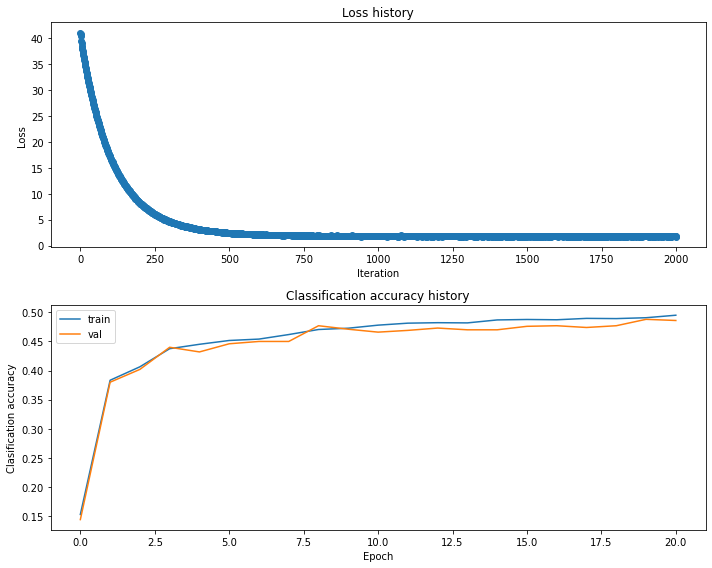

In [15]:
input_size = 32 * 32 * 3
num_classes = 10
net = FullyConnectedNet(input_size,[100,100],num_classes,reg=0.6,weight_scale=2e-2)
# 训练网络
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=500,
            learning_rate=8e-3, learning_rate_decay=0.95,
            verbose=False)
# 测试性能
val_acc =(net.predict(X_val) == y_val).mean()
print('验证精度: ', val_acc)
print('最佳验证精度: ', stats['best_val_acc'])
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'],'o')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
# 添加图标
plt.legend()
# 控制布局
plt.tight_layout()
plt.show()

In [25]:
best_net = None
##########################################################################
#               任务：尽可能训练一个最佳的深层神经网络                   #
##########################################################################
input_size = 32 * 32 * 3
num_classes = 10

# 进行探查
lr = np.array([1e-3, 8e-3, 4e-3])
ws = np.array([1e-2, 2e-2, 1e-1])
# 记录最好的参数
best_lr = 0.0
best_ws = 0.0
best_val_acc = 0.0

for l in lr:
    for w in ws:
        net = FullyConnectedNet(input_size, [100, 100, 32], num_classes, reg=0.6,weight_scale=w)
        stats = net.train(X_train, y_train, X_val, y_val,
                    num_iters=2500, batch_size=500,
                    learning_rate=l, learning_rate_decay=0.95,
                    verbose=False)
        # 测试性能
        val_acc =(net.predict(X_val) == y_val).mean()
        if val_acc > best_val_acc:
            best_net = net
            best_lr = l
            best_ws = w
            best_val_acc = val_acc
            
print('验证学习率: ', best_lr)
print('验证权重: ', best_ws)
print('验证精度: ', val_acc)
print('最佳验证精度: ', stats['best_val_acc'])

##########################################################################
#                      结束编码                                          #
##########################################################################

D:\workspace\Python\jupyter\深度学习实战范例\DLAction\classifiers\chapter3\layers.py:199: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


验证学习率:  0.008
验证权重:  0.02
验证精度:  0.196
最佳验证精度:  0.203


In [ ]:
test_acc =(best_net.predict(X_test) ==y_test).mean()
print('Test accuracy: ', test_acc)